In [161]:
#import all necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import random
import time
import re
import os
import patsy
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from mlxtend.plotting import plot_linear_regression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
#data was still missing necessary values, so I decided to work with the kaggle dataset instead.

pokedf = pd.read_csv('/Users/randy/Downloads/pokemon.csv') #Original data



In [3]:
#simplest of dataframes, drops type1,type2 as well. Multiple sources note that height/weight don't matter 
#except for gourgion? so I will drop those for the sake of the dataset
pokedf1 = pokedf.drop(columns=['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'height_m', 'weight_kg', 'name', 'generation',
       'type1','type2','against_rock', 'against_steel', 'against_water', 'japanese_name',
       'base_egg_steps', 'base_happiness', 'capture_rate', 'base_total',
       'classfication', 'experience_growth', 'percentage_male', 'pokedex_number', 'is_legendary'])

In [4]:
pokedf1.isnull().any() #check for any NaN values. Could also use 'pokedf1.isnull().values.any()'

attack        False
defense       False
hp            False
sp_attack     False
sp_defense    False
speed         False
dtype: bool

In [5]:
pokedf1.info() #get the basic info from the dataset, ensure there are values for each row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 6 columns):
attack        801 non-null int64
defense       801 non-null int64
hp            801 non-null int64
sp_attack     801 non-null int64
sp_defense    801 non-null int64
speed         801 non-null int64
dtypes: int64(6)
memory usage: 37.6 KB


In [6]:
pokedf1.shape

(801, 6)

In [7]:
# pokedf1.corr()
#A correlation matrix is a table showing correlation coefficients between variables. 
#how to read this correlation matrix:
#+1 is a perfect (uphill) positive relationship. As it increases, the other parameter increases by the exact
#same amount
#0 is no relationship. 
#generation is showing a very weak correlation to everything
#it's not a case of "as hp increases by 1 point defense increases by 0.46", but instead it's a measure of
#relationship strength



,attack,defense,hp,sp_attack,sp_defense,speed
attack,1.000000,0.468915,0.410616,0.368154,0.265836,0.352703
defense,0.468915,1.000000,0.242378,0.241882,0.526348,0.007934
hp,0.410616,0.242378,1.000000,0.365973,0.366971,0.160760
sp_attack,0.368154,0.241882,0.365973,1.000000,0.511496,0.438981
sp_defense,0.265836,0.526348,0.366971,0.511496,1.000000,0.225977
speed,0.352703,0.007934,0.160760,0.438981,0.225977,1.000000


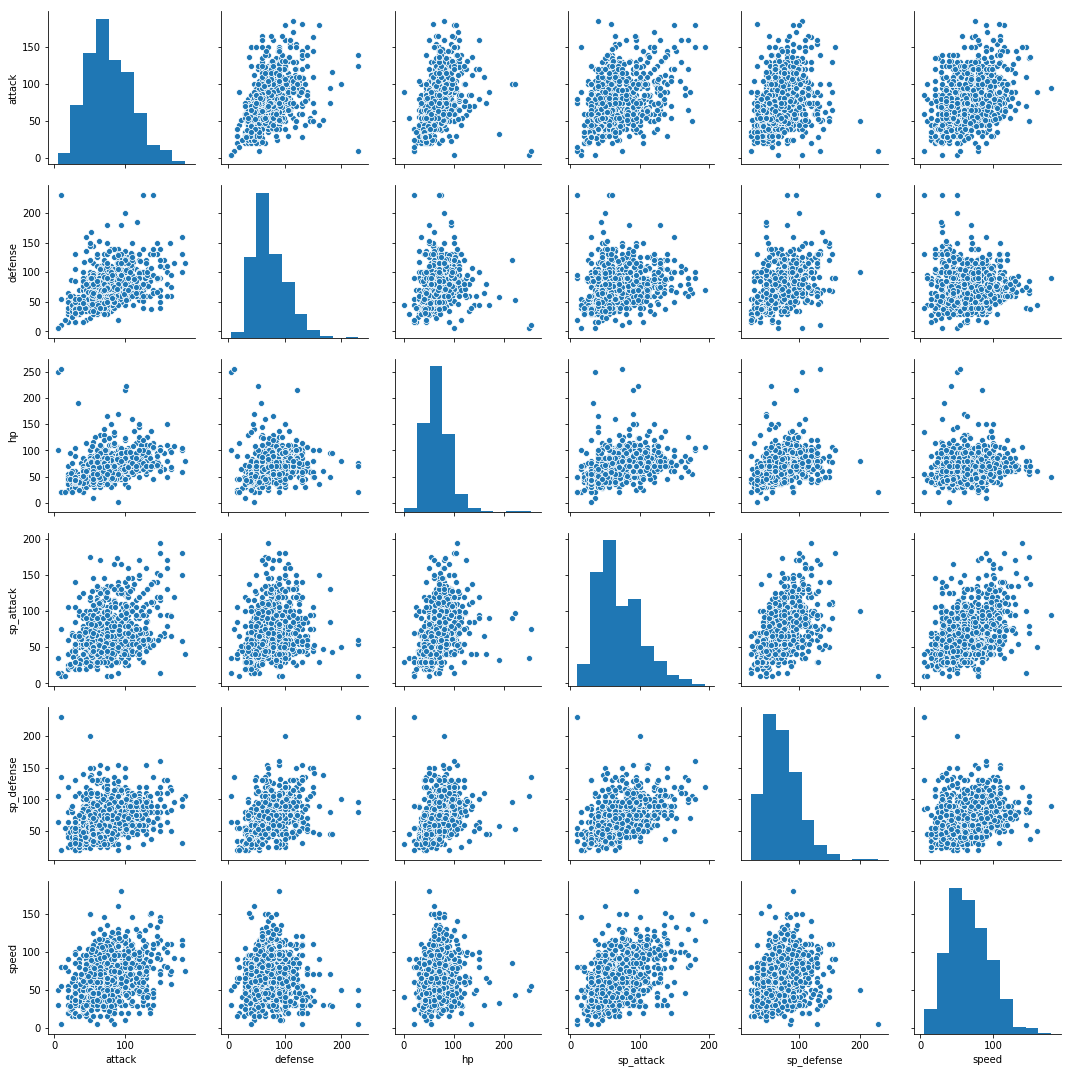

In [8]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(pokedf1); #, height=1.2, aspect=1.5 to change the display of the chart


In [9]:
#pokedf2 = pokedf1**2
#pokedf2 = np.log(pokedf1)

In [10]:
# sns.pairplot(pokedf2); #, height=1.2, aspect=1.5 to change the display of the chart


In [11]:
#check correlation of stats to each other
pokedf1.corr()

,attack,defense,hp,sp_attack,sp_defense,speed
attack,1.000000,0.468915,0.410616,0.368154,0.265836,0.352703
defense,0.468915,1.000000,0.242378,0.241882,0.526348,0.007934
hp,0.410616,0.242378,1.000000,0.365973,0.366971,0.160760
sp_attack,0.368154,0.241882,0.365973,1.000000,0.511496,0.438981
sp_defense,0.265836,0.526348,0.366971,0.511496,1.000000,0.225977
speed,0.352703,0.007934,0.160760,0.438981,0.225977,1.000000


In [12]:
# for item in result.columns:
#     print(item + " + ")

In [136]:
#creating a string of pokemon types to add to the tests below.
type_string = """
bug + 
dark + 
dragon + 
electric + 
fairy + 
fighting + 
fire + 
flying + 
ghost + 
grass + 
ground + 
ice + 
normal + 
poison + 
psychic + 
rock + 
steel + 
water
"""

type_string2 = """
bug + 
dark + 
dragon + 
electric + 
fairy + 
fighting + 
ghost + 
grass + 
ground + 
normal + 
rock + 
steel + 
water
"""

type_string3 = """

rock + 
steel
"""

I attempt to run a few tests to see what gives a high R-squared and high adjusted R-squared. I'm also trying to be mindful of multicollinearity (which was the case when base_total was still on the possible stats).

In [214]:
# test0 = 'hp ~ defense + attack + sp_attack + sp_defense + speed'
# test1 = 'attack ~ defense + hp + sp_attack + sp_defense + speed'
test2 = f'defense ~ hp + attack + sp_attack + sp_defense + speed + weight_kg + {type_string}'
test3 = 'defense ~ hp + attack + sp_attack + sp_defense + speed + weight_kg'
# test4 = 'sp_defense ~ defense + attack + hp + sp_attack + speed'
# test5 = 'speed ~ defense + attack + hp + sp_defense + sp_attack'

# #tests hp against other stats + types
# test6 = f'hp ~ defense + attack + sp_attack + sp_defense + speed + {type_string}'

#tests def against other stats + types
# test7 = f'defense ~ sp_defense + attack + sp_attack + hp + speed + {type_string}'

# #tests attack against other stats + types
# test8 = f'attack ~ defense + sp_defense + sp_attack + hp + speed + {type_string}'

# #tests sp_attack against other stats + types
# test9 = f'sp_attack ~ defense + attack + sp_defense + hp + speed + {type_string}'

# #tests sp-defense against other stats + types
# test10 = f'sp_defense ~ defense + attack + sp_attack + hp + speed + {type_string}'

# #tests speed against other stats + types
# test11 = f'speed ~ defense + attack + sp_attack + hp + sp_defense + {type_string}'

In [242]:
# test_list = [test0, test1, test2, test3, test4, test5, test6, test7, test8, test9, test10, test11]
# test_list = [test2,test7]
# for item in test_list:    
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(test2, data=result, return_type='dataframe')

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                defense   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     41.69
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          5.60e-121
Time:                        00:07:31   Log-Likelihood:                -3455.5
No. Observations:                 781   AIC:                             6961.
Df Residuals:                     756   BIC:                             7078.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9152      3.623      6.326      0.000      15.804      30.027
hp            -0.0930      0.035     -2.666      0.008      -0.161      -0.025
attack         0.3398      0.031     11.015      0.000       0.279       0.400
sp_attack     -0.0376      0.033     -1.138      0.256      -0.103       0.027
sp_defense     0.5010      0.033     15.384      0.000       0.437       0.565
speed         -0.1432      0.032     -4.487      0.000      -0.206      -0.081
weight_kg      0.0399      0.008      4.827      0.000       0.024       0.056
bug            4.3601      2.874      1.517      0.130      -1.282      10.002
dark          -2.6469      3.411     -0.776      0.438      -9.343       4.050
dragon         0.5818      3.617      0.161      0.872      -6.519       7.683
electric      -1.5799      3.753     -0.421      0.674      -8.947       5.787
fairy         -2.5240      3.475     -0.726      0.468      -9.345       4.297
fighting      -3.0310      3.409     -0.889      0.374      -9.722       3.660
fire          -0.2204      3.254     -0.068      0.946      -6.607       6.167
flying        -0.1747      2.447     -0.071      0.943      -4.977       4.628
ghost          3.4118      3.629      0.940      0.347      -3.713      10.537
grass          2.4860      2.742      0.907      0.365      -2.897       7.869
ground         6.6702      3.194      2.089      0.037       0.401      12.940
ice           -1.8634      3.930     -0.474      0.636      -9.579       5.852
normal        -2.8854      2.993     -0.964      0.335      -8.761       2.990
poison        -1.4119      3.039     -0.465      0.642      -7.377       4.554
psychic        1.2976      3.064      0.423      0.672      -4.718       7.313
rock          21.8683      3.198      6.838      0.000      15.590      28.147
steel         24.7252      3.435      7.197      0.000      17.981      31.469
water          5.6075      2.605      2.153      0.032       0.494      10.721
==============================================================================
Omnibus:                      151.881   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.573
Skew:                           0.923   Prob(JB):                    1.09e-107
Kurtosis:                       6.425   Cond. No.                     1.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [245]:

print('Parameters: ', fit.params)
print('Standard errors: ', fit.bse)
print('Predicted values: ', len(fit.predict()))

Parameters:  Intercept     22.915160
hp            -0.092958
attack         0.339833
sp_attack     -0.037627
sp_defense     0.501016
speed         -0.143173
weight_kg      0.039897
bug            4.360129
dark          -2.646944
dragon         0.581806
electric      -1.579869
fairy         -2.524050
fighting      -3.030985
fire          -0.220434
flying        -0.174666
ghost          3.411835
grass          2.485952
ground         6.670177
ice           -1.863352
normal        -2.885447
poison        -1.411881
psychic        1.297618
rock          21.868322
steel         24.725231
water          5.607538
dtype: float64
Standard errors:  Intercept     3.622640
hp            0.034871
attack        0.030851
sp_attack     0.033070
sp_defense    0.032568
speed         0.031907
weight_kg     0.008265
bug           2.874204
dark          3.411167
dragon        3.617187
electric      3.752658
fairy         3.474804
fighting      3.408591
fire          3.253524
flying        2.446528
ghost    

In [244]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(test3, data=result, return_type='dataframe')

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit1 = model.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                defense   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     125.0
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          2.39e-110
Time:                        00:07:33   Log-Likelihood:                -3520.1
No. Observations:                 781   AIC:                             7054.
Df Residuals:                     774   BIC:                             7087.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.4910      3.065      9.622      0.000      23.475      35.507
hp            -0.1608      0.036     -4.512      0.000      -0.231      -0.091
attack         0.3985      0.030     13.408      0.000       0.340       0.457
sp_attack     -0.0547      0.032     -1.721      0.086      -0.117       0.008
sp_defense     0.5418      0.034     16.002      0.000       0.475       0.608
speed         -0.2158      0.032     -6.778      0.000      -0.278      -0.153
weight_kg      0.0557      0.008      6.601      0.000       0.039       0.072
==============================================================================
Omnibus:                      179.895   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              539.694
Skew:                           1.121   Prob(JB):                    6.41e-118
Kurtosis:                       6.399   Cond. No.                         726.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#create dummy variables for type1/type2. no drops since the two types will overlap
df4 = pd.get_dummies(pokedf['type1'])
df5 = pd.get_dummies(pokedf['type2'])
#add both values from df4 and df5 since they are the same columns with different values
df6 = df4+df5
frames = [pokedf,df6] #df1,df2,df3,df4,df5
result = pd.concat(frames,axis=1)


In [16]:
result_heatmap = result.drop(columns=['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'base_total',
       'against_rock', 'against_steel', 'against_water', 'japanese_name',
       'base_egg_steps', 'base_happiness', 'capture_rate',
       'classfication', 'experience_growth', 'percentage_male', 'pokedex_number', 'is_legendary'])

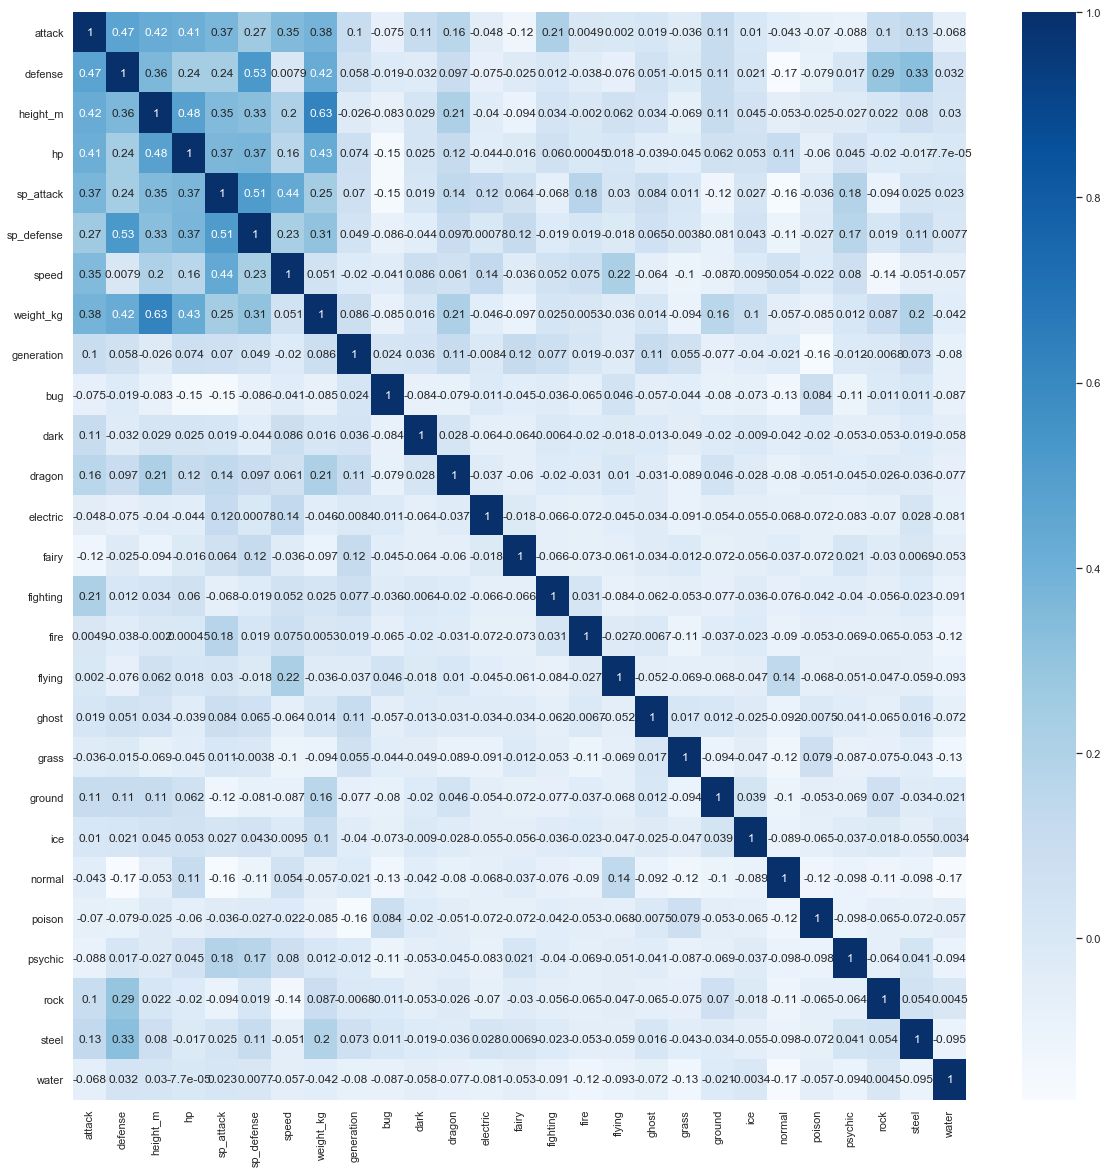

In [250]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(result_heatmap.corr(), cmap="Blues", ax=ax, annot=True)
plt.show()


#attack/height_m/hp/sp_attack/sp_defense/weight_kg/rock/steel/ground/bug - high defense
#fighting - higher attack

In [229]:
result_heatmap2 = result_heatmap.drop(columns=['speed','generation','dark','dragon','electric','fairy','fighting',
                                              'fire','flying','ghost','grass','ice','normal','poison','psychic',
                                               'water'])


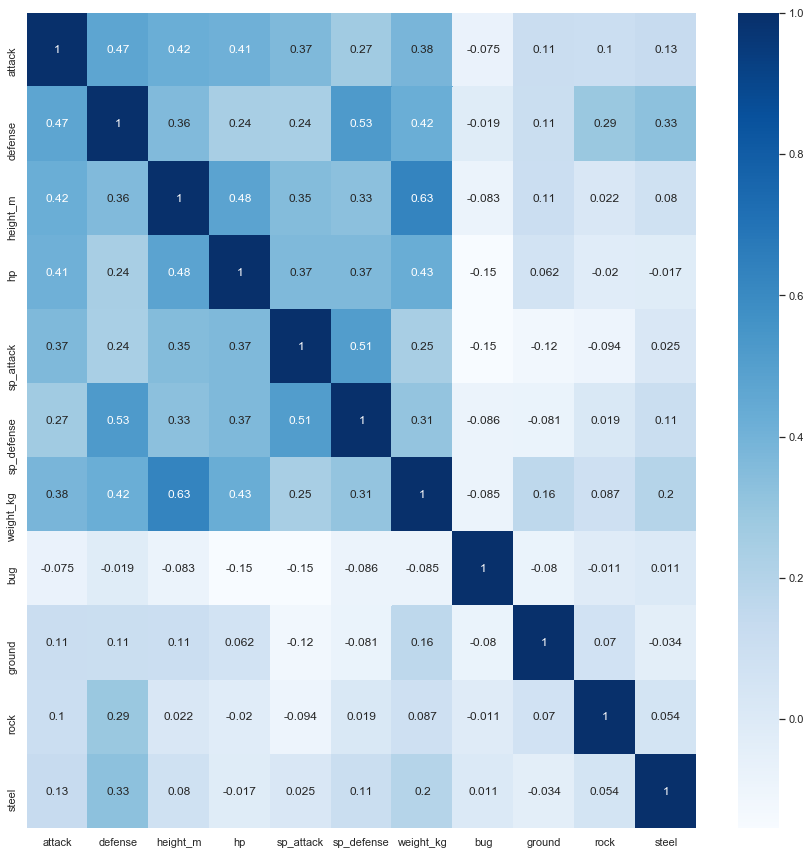

In [249]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(result_heatmap2.corr(), cmap="Blues", ax=ax, annot=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(result_heatmap.corr(), cmap="Blues", ax=ax)
plt.show()

Here are my notes on how to read the OLS Regression Results:
 * Dep. Variable - the Y-value. It is the variable acting as the response in the model.
 * Model - The model used in the fit
 * No. Observations - # of observations
 * Df Residuals - degrees of freedom of the residuals (# of obs - # of parameters, usually N-1)
 * Df Model - # of parameters in the model
 * R-squared - (coefficient of determination) A statistical measure of how well the regression line approximates the real data points
 * Adjusted R-squared - R-squared adjusted based on the # of observations and Df Residuals
 * F-statistic - a measure of how significant the fit is
 * Prob (F-statistic) - The probability that you would get the above statistic, given the null hypothesis that they are unrelated
 * Log-Likelihood - the likelihood the model will produce the results we expect. (I think I want this close to 0?)
 * pvalue <= 0.05 means strong evidence against the null hypothesis (you can reject the null hypothesis)
 * pvalue >= 0.05 means not significant; you can't reject the null hypothesis

In [19]:
# for item in enumerate(result.columns):
#     print(item)

In [85]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = result.iloc[:, [19,28,33,34,35]] #takes attack, hp, sp_attack, sp_defense, speed

# Choose the response variable(s)
y = result.iloc[:, 25] #defense

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.4555125073494378

This agrees to the OLS report above

In [21]:
# print out intercept
print(lr.intercept_)

# print out other coefficients
lr.coef_


24.847901673612192


array([ 0.44981462, -0.09160137, -0.0602191 ,  0.56780954, -0.24895214])

In [227]:
# pokedf1.corr()

781

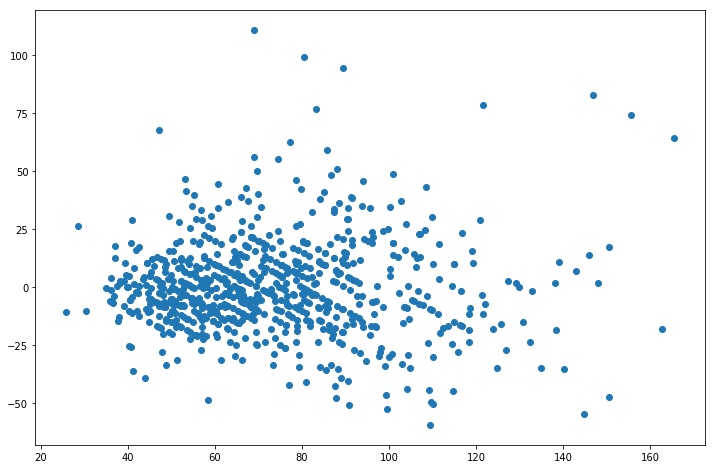

In [114]:
# Use statsmodels to plot the residuals vs the fitted values

plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);
#this shows the error of the data points to the actual models


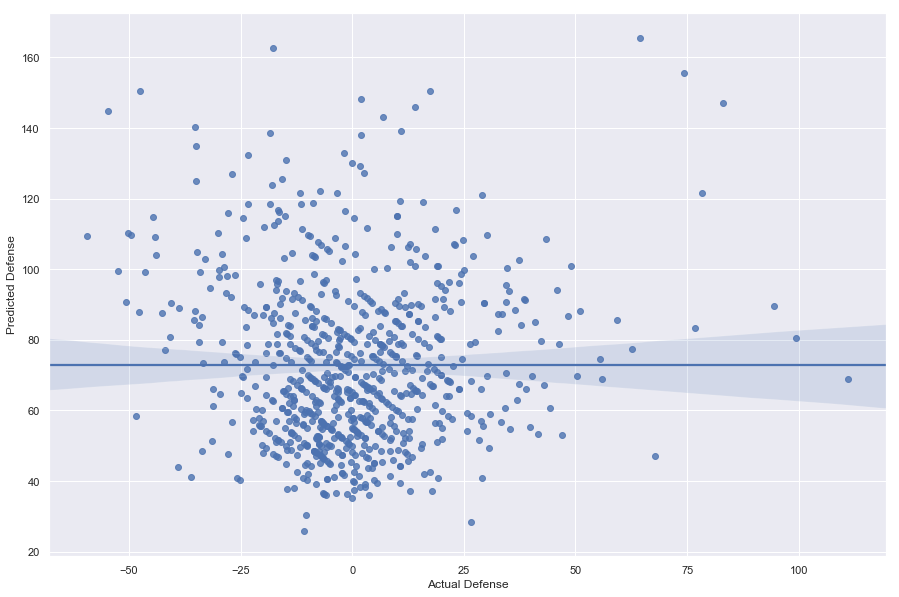

In [234]:
sns.set(rc={'figure.figsize':(15,10)})
actual_def, pred_def = pd.Series(fit.resid, name="Actual Defense"), pd.Series(fit.predict(), name="Predicted Defense")
ax = sns.regplot(x=actual_def, y=pred_def, data=data)

In [28]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=10)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val), 1 - (1-lr_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    # report results
    print('\nValidation R^2 score was:', val_score[0])
    print('Validation Adjusted R^2 score was:', val_score[1])
    print('\nFeature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [32]:
split_and_validate(X, y)


Validation R^2 score was: 0.4238279111572652
Validation Adjusted R^2 score was: 0.4506819328475321

Feature coefficient results: 

attack : 0.45
hp : -0.09
sp_attack : -0.04
sp_defense : 0.55
speed : -0.28


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [87]:
#must scale variables before elasticNetting

scaler = StandardScaler()
scaler.fit(X_train)

#break out into 80/20 for training
x_norm = scaler.transform(X_train)

#normalize the 20% for training
x_norm_test = scaler.transform(X_test)

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [88]:
# Define grid search to find the optimal lambda and l1_ratio for an Elastic Net Regression

alphas = [i/1000 for i in range(10,100)]
l1_ratios = [i/100 for i in range(90,101)]
param_grid = [{'alpha': alphas, 'l1_ratio': l1_ratios}]
elastic = GridSearchCV(ElasticNet(alpha=1, l1_ratio=0.5), param_grid, cv=7, scoring='r2', return_train_score=True)
elastic.fit(x_norm, y_train)
y_elastic = elastic.predict(x_norm)

print(elastic.best_params_)
print(elastic.best_score_)
#lasso is L1, Ridge is L2
# {'alpha': 0.06, 'l1_ratio': 0.9} --> plug back into a normal elasticNet
# 0.4408021184987252   <- the mean_squared_error

{'alpha': 0.06, 'l1_ratio': 0.9}
0.4408021184987252


In [138]:
enet = ElasticNet(alpha=0.06)
y_pred_enet = enet.fit(X_train, y_train).predict(X_test)

In [40]:
enet.coef_

array([ 0.44595703, -0.09098177, -0.04486817,  0.5527832 , -0.28340549])

Mean squared error (MSE), also known as Mean squared deviation (MSD) is a measure of quality of a prediction model.  
  
Since my MSE is at 582, far from the near-zero goal.

In [151]:
MSE = mean_squared_error(y_test, y_pred_enet, sample_weight=None)
MSE

582.4183830076109

In [152]:
RMSE = MSE**0.5
RMSE

24.1333458726222

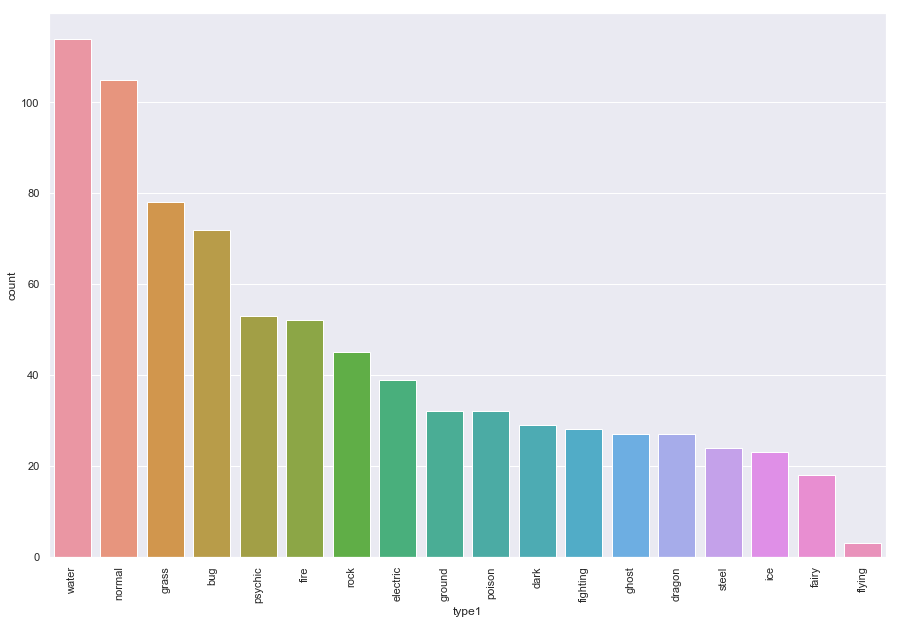

In [222]:
sns.countplot(x='type1', data=pokedf, order=pokedf['type1'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

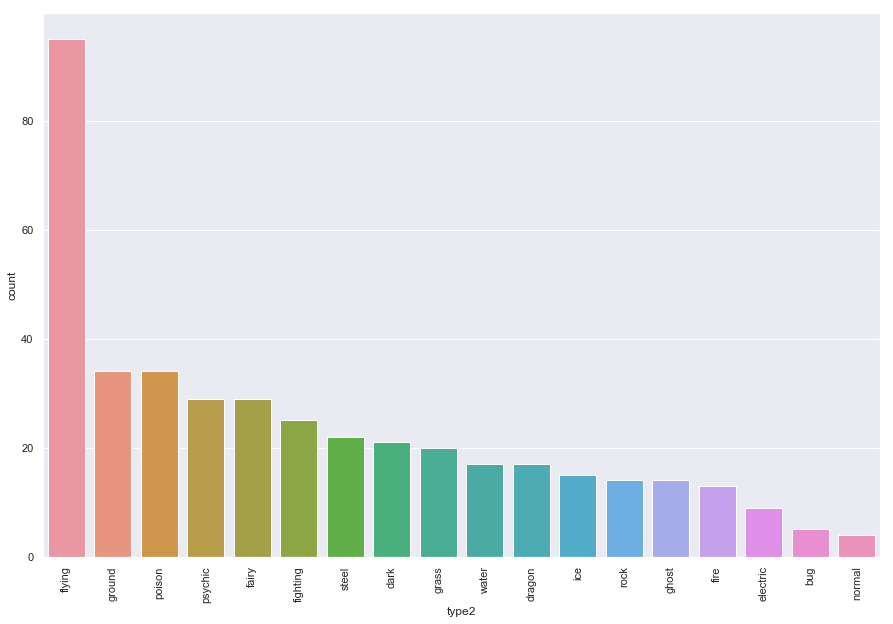

In [223]:
sns.countplot(x='type2', data=pokedf, order=pokedf['type2'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [107]:
# newdf = y_test,y_pred_enet

In [247]:
# for actuals_vs_predictions in zip(y_test,newdf):
#     print(actuals_vs_predictions)

In [43]:
# X2 = X.copy()
# #adds the new column
# X2['type1'] = result['type1']
# X2['type2'] = result['type2']

# split_and_validate(pd.get_dummies(X2), y)

In [44]:
X2v2 = X.copy()

In [45]:
X2v2[['bug','dark','dragon','electric','fairy','fighting', 'fire','flying','ghost','grass','ground','ice','normal', 
'poison','psychic','rock','steel','water']] = result[['bug','dark','dragon','electric','fairy',
'fighting','fire','flying','ghost','grass','ground','ice','normal', 'poison','psychic','rock','steel','water']]

In [46]:
split_and_validate(pd.get_dummies(X2v2), y)


Validation R^2 score was: 0.5664457685851788
Validation Adjusted R^2 score was: 0.5331250349538347

Feature coefficient results: 

attack : 0.37
hp : -0.04
sp_attack : -0.02
sp_defense : 0.49
speed : -0.20
bug : 3.66
dark : -2.57
dragon : -1.43
electric : -1.89
fairy : -2.22
fighting : -3.24
fire : -2.29
flying : 1.81
ghost : 0.00
grass : 2.08
ground : 6.44
ice : 2.05
normal : -4.23
poison : -2.32
psychic : 0.98
rock : 19.13
steel : 27.44
water : 5.14


In [83]:
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.435


/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


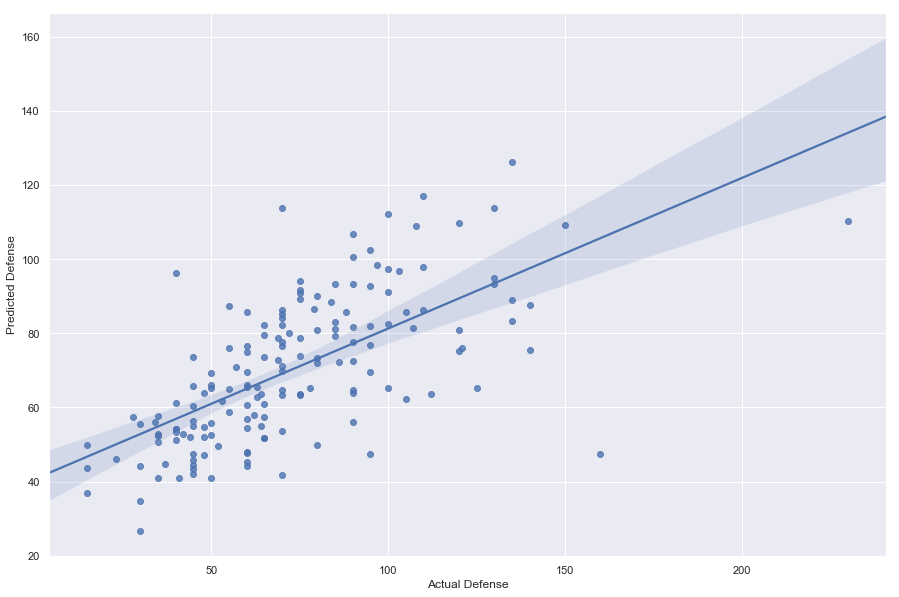

In [208]:
sns.set(rc={'figure.figsize':(15,10)})
actual_def, pred_def = pd.Series(y_test, name="Actual Defense"), pd.Series(y_pred_enet, name="Predicted Defense")
ax = sns.regplot(x=actual_def, y=pred_def, data=data)

In [48]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.05395461, 0.52582082, 0.49884844, 0.48172062, 0.41578617])

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.46029778, 0.41750709, 0.39401874, 0.46686081, 0.48497832])

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.44401973933807354
0.4440197669126659


In [51]:
#do an elastic net with all of this data - done
#plot the residuals for each of the data - done
#I have my models, now do feature transformation
#find the RMSE (root mean squared error) - done

In [210]:
# m = result[['attack']]
# j = result[['defense']]

# body_reg = linear_model.LinearRegression()
# body_reg.fit(m,j)

# plt.scatter(m,j)
# plt.xlabel('attack')
# plt.ylabel('defense')

# plt.plot(m, body_reg.predict(m))
# plt.show()

In [ ]:

# plt.figure(figsize=(20,10))
# n = y_test
# o = y_pred_enet
# plt.scatter(n,o)
# plt.xlabel('Actual Defense Stat')
# plt.ylabel('Predicted Defense Stat')
# # plt.plot(n,o, color='red')
# plt.show()

In [76]:
p = features
l = targets

model = linear_model.LinearRegression()
model.fit(p,l)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [116]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [248]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

NameError: name 'X_val' is not defined